Uvoz knjižnic in branje podatkov iz datotek:

In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
import operator

In [2]:
list_of_cvs = ["./podatki/kd{}.csv".format(i) for i in range(2010,2020)]
frames = [pd.read_csv(csv,sep=';', encoding="UTF-8", dtype={'MesecStoritve': str}) for csv in list_of_cvs]
df = pd.concat(frames)

C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_11300\1644075804.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(csv,sep=';', encoding="UTF-8", dtype={'MesecStoritve': str}) for csv in list_of_cvs]
C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_11300\1644075804.py:2: DtypeWarning: Columns (14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_csv(csv,sep=';', encoding="UTF-8", dtype={'MesecStoritve': str}) for csv in list_of_cvs]


In [3]:
dfGroupedBySex = df.groupby(["Spol"]);

In [4]:
# { sex: {year: count} }
crimesBySex = {};
for sex, bySexData in dfGroupedBySex:
    if(sex not in crimesBySex):
        crimesBySex[sex] = defaultdict(int);
    for yearStr in bySexData["MesecStoritve"].values:
        year = int(yearStr.split(".")[1]);
        crimesBySex[sex][year] += 1;
#print(crimesBySex);

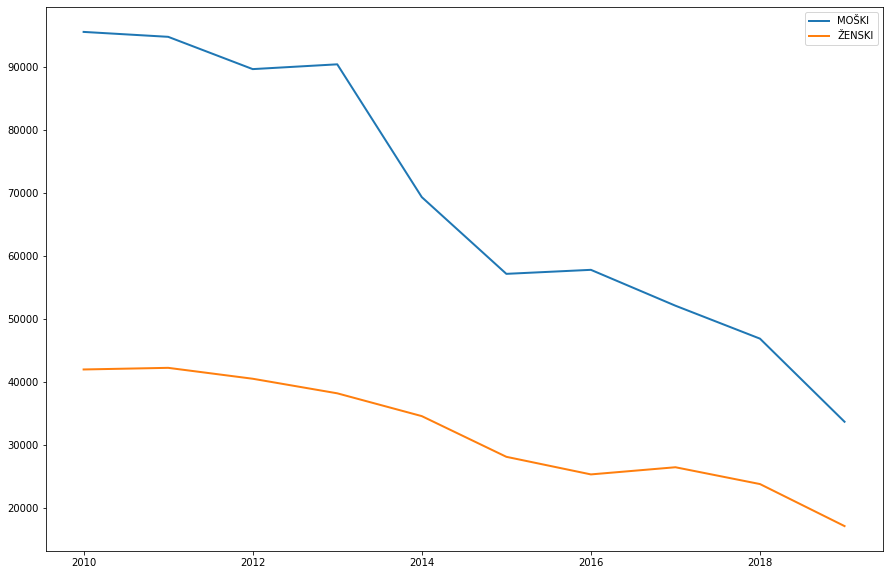

In [5]:
plt.figure(figsize=(15,10));
for sex, crimesPerYear in crimesBySex.items():
    if(sex != "MOŠKI" and sex != "ŽENSKI"):
        continue;
    sortedYears = [ year for year in sorted(crimesPerYear.keys()) if(2010 <= year < 2020) ];
    crimesPerSortedYear = [ crimesPerYear[year] for year in sortedYears ];
    plt.plot(sortedYears, crimesPerSortedYear, label=sex, linewidth=2.0);
plt.legend();

Kazniva dejanja po letih:

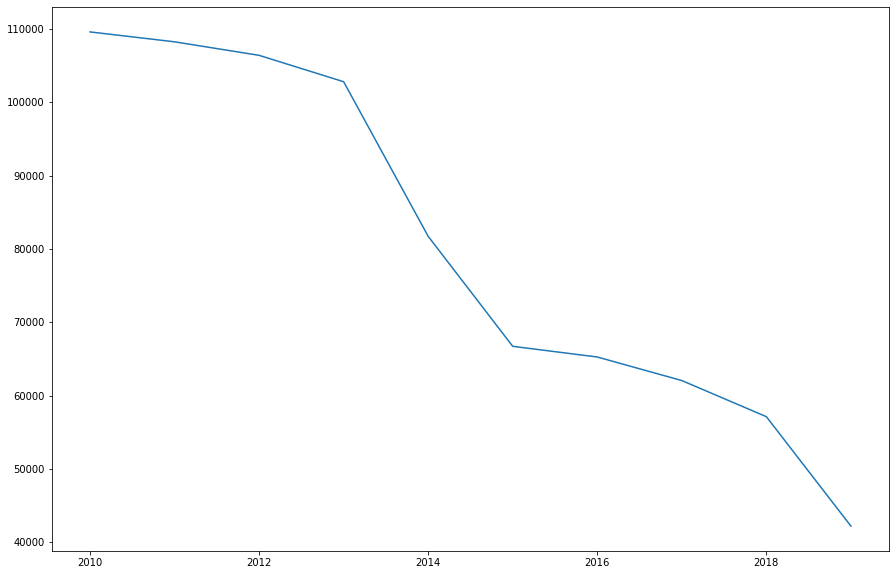

In [6]:
#group by mesec, count unique id
kd_leto = df.groupby(['MesecStoritve', 'UraStoritve','ZaporednaStevilkaKD'])
leto_counter = defaultdict(int)

for name,v in kd_leto:
    index = int((name[0].split(".")[1]))
    if index >= 2010 and index < 2020:
        leto_counter[index] +=1
    
    
list_mes_counter = sorted(leto_counter.items())
mesec, counter = zip(*list_mes_counter)
plt.figure(figsize=(15,10))
plt.plot(mesec,counter)
plt.show()

Porazdelitev kaznivih dejanj po mesecih:

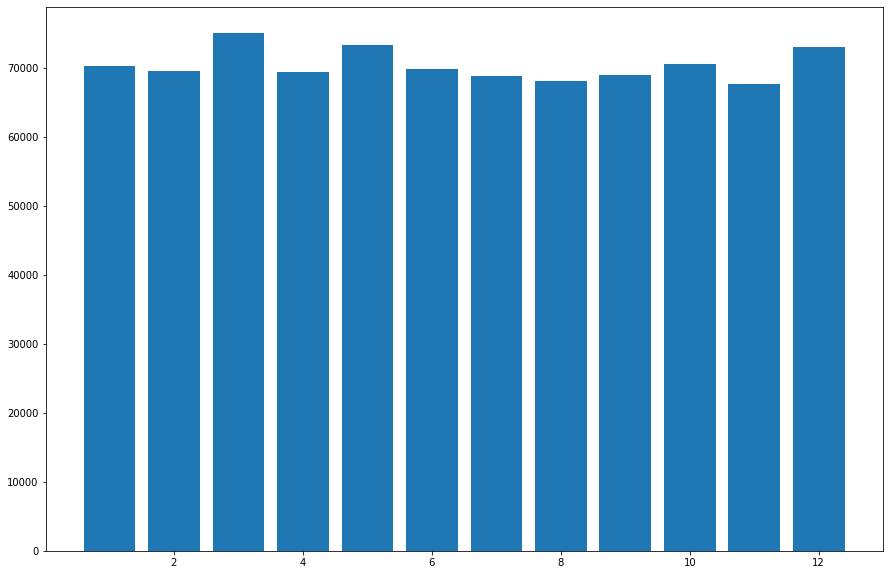

In [7]:
kd_mes = df.groupby(['MesecStoritve', 'UraStoritve','ZaporednaStevilkaKD'])
mes_counter = defaultdict(int)

for name,v in kd_mes:
    index = int((name[0].split(".")[0]))
    mes_counter[index] +=1


list_mes_counter = sorted(mes_counter.items())
mesec, counter = zip(*list_mes_counter)
plt.figure(figsize=(15,10))
plt.bar(mesec,counter)
plt.show()

Udeleženci v kaznivih dejanjih porazdeljeni po starostnih razredih:

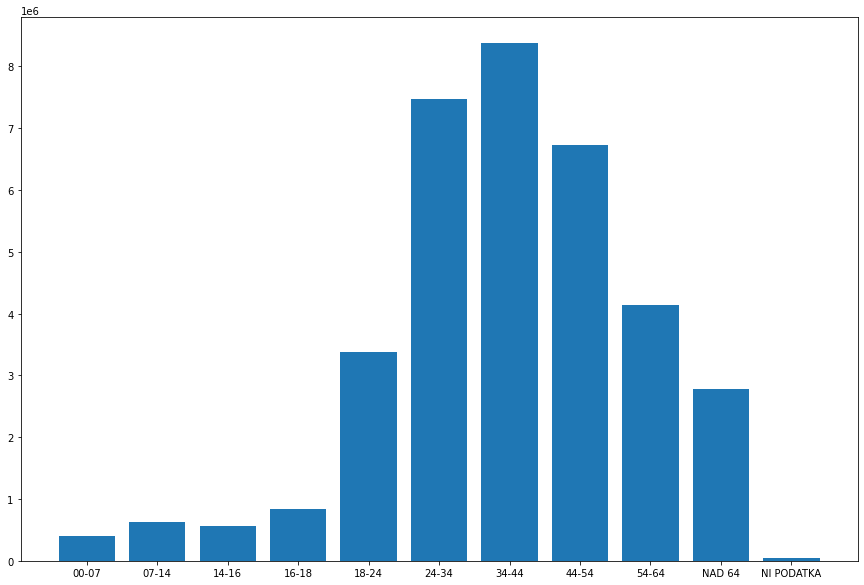

In [8]:
star_razredi = df.groupby(['StarostniRazred'])
star_razred, star_stevilo = zip(*[(name,razred.size) for name, razred in star_razredi])

star_stevilo = list(star_stevilo)
star_stevilo[-3] += star_stevilo[-2]

plt.figure(figsize=(15,10))
plt.bar(star_razred[:-2],star_stevilo[:-2])
plt.show()
#plt.pie(star_stevilo[:-3], labels=star_razred[:-3])

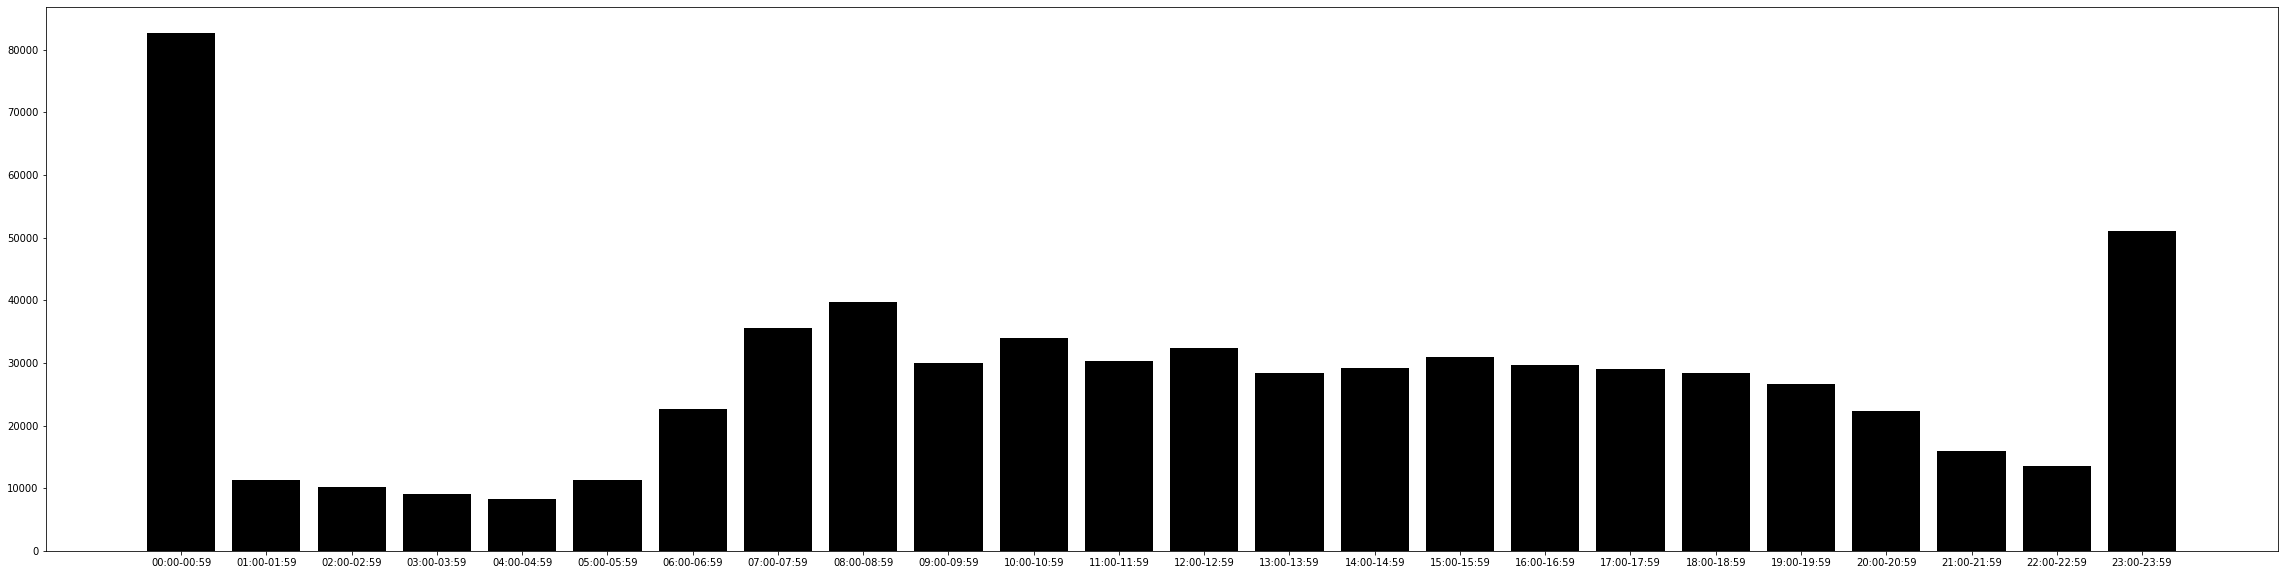

In [9]:
#group by mesec, count unique id
kd_ura = df.groupby(['UraStoritve', 'ZaporednaStevilkaKD'])
ura_counter = defaultdict(int)

for name,v in kd_ura:
    ura_counter[name[0]] += 1


list_ura_counter = sorted(ura_counter.items())
ura, counter = zip(*list_ura_counter)
plt.figure(figsize=(40,10))
plt.bar(ura,counter, color="black")
plt.show()

In [10]:
from PIL import Image
#pip install reportlab
from reportlab.graphics import renderPM
#pip install svglib
from svglib.svglib import svg2rlg

def getPILImage( pathToSVG ):
    drawing = svg2rlg( pathToSVG );
    return renderPM.drawToPILP( drawing );

#pip install unidecode
from unidecode import unidecode


import re
from pathlib import Path

def puMapingService( puName ):
    if ( puName == "PU LJUBLJANA" ):
        return "PU-LJ";
    elif  ( puName == "PU CELJE" ):
        return "PU-CE";
    elif  ( puName == "PU KRANJ" ):
        return "PU-KR";
    elif  ( puName == "PU KOPER" ):
        return "PU-KP";
    elif  ( puName == "PU KRANJ" ):
        return "PU-KR";
    elif  ( puName == "PU MARIBOR" ):
        return "PU-MB";
    elif  ( puName == "PU MURSKA SOBOTA" ):
        return "PU-MS";
    elif  ( puName == "PU NOVA GORICA" ):
        return "PU-NG";
    elif  ( puName == "PU NOVO MESTO" ):
        return "PU-NM";
    else:
        return puName;

def getModifiedPUStats( stats ):
    return { puMapingService(pu): max( 0.17, normVal ) for pu, normVal in stats.items() }
    
def getTextAndLegendForSvg( name, date ):
    return """    <text x="20" y="35" style="fill: black; font: bold 27.5px sans-serif;">
        %s
        <tspan x="20" y="65" style="font: bold 24px sans-serif;">%s</tspan>
        <tspan x="13" y="100" style="font: bold 22px arial;">Legenda:</tspan>
        <tspan x="10" y="140" style="font: bold 20px arial;">0</tspan>
        <tspan x="230" y="140" style="font: bold 20px arial;">100</tspan>
    </text>
    <rect x="15" y="107" width="30" height="15" style="fill: #000000; fill-opacity: 0.17;" />
    <rect x="45" y="107" width="30" height="15" style="fill: #000000; fill-opacity: 0.27;" />
    <rect x="75" y="107" width="30" height="15" style="fill: #000000; fill-opacity: 0.37;" />
    <rect x="105" y="107" width="30" height="15" style="fill: #000000; fill-opacity: 0.47;" />
    <rect x="135" y="107" width="30" height="15" style="fill: #000000; fill-opacity: 0.57;" />
    <rect x="165" y="107" width="30" height="15" style="fill: #000000; fill-opacity: 0.75;" />
    <rect x="195" y="107" width="30" height="15" style="fill: #000000; fill-opacity: 0.87;" />
    <rect x="225" y="107" width="30" height="15" style="fill: #000000; fill-opacity: 1;" />
    """ % ( unidecode( name ), unidecode( date ) );

def transformSvgPathLine( line, fillColor ):
    return line.rstrip()[:-1] + " fill-opacity=\"%s\">\n" % fillColor;
    
# stats = { "PU_X": normVal, ...  }
def getModifiedSVG( pathToSvg, stats, frameName, month ):
    colorPerPU = getModifiedPUStats( stats );
    svg = "";
    with open(pathToSvg) as file:
        for line in file:
            if ( line.lstrip().startswith( "<path d=" ) ):
                matchedID = re.findall( 'id="PU-..', line );
                if ( len( matchedID ) != 1 ):
                    print( "ERROR in ", line, matchedID );
                    svg += line;
                    continue;
                pu = re.findall( "PU-..", matchedID[0] )[0];
                if ( pu not in colorPerPU ):
                    #print("Unknown PU:", pu, "- will have default color fill");
                    svg += line;
                    continue;
                svg += transformSvgPathLine( line, colorPerPU[pu] );
            elif ( line.lstrip().startswith( "</svg>" ) ):
                svg += getTextAndLegendForSvg( frameName, month ) + line;
            else:
                svg += line;
    return svg;

pathToSIPUFile = Path( "./misc/si_pu.svg" );

def getFrame( stats, frameName, month ):
    pathToTempSvg = Path( "./temp/temp.svg" );
    pathToTempSvg.parent.mkdir(parents=True, exist_ok=True);
    svg = getModifiedSVG( pathToSIPUFile, stats, frameName, month );
    with open( pathToTempSvg, "w" ) as svgFile:
        svgFile.write( svg );
    return getPILImage( pathToTempSvg );

# allStats = [ (datum, {'PU': normVal, ...}), ... ]
def getGif( allStats, gifName ):
    frames = [];
    for date, stats in allStats:
        frames.append( getFrame( stats, gifName, date ) );
    return frames;
    
def saveGif( frames, path ):
    frames[0].save(path, save_all=True, append_images=frames[1:], optimize=False, duration=150, loop=1)

def generateGif( allStats, gifName, gifPath ):
    saveGif( getGif( allStats, gifName ), gifPath );


#tempAllStats =  [ ('0.0', { "PU LJUBLJANA": 0.2 }), ('0.1', { "PU CELJE": 0.0 }) ];
#generateGif( tempAllStats, "Test", "./misc/temp.gif" );

In [11]:
df["TIP-DEJANJA"] = df.apply(lambda row: row["OpisKD"].split(" - ")[1], axis=1)

In [12]:
kd = df.groupby(["TIP-DEJANJA"])
kd.ngroups

tip_dogodki = defaultdict(set)

for k, v in kd:
    if k== "": continue
    for val in v.values:
        if val[4] in ["GPU", "DIREKTORAT ZA UPRAVNE NOTRANJE ZADEVE", "NI PODATKA"]: continue
        tip_dogodki[k].add((val[4],val[1] ,val[0], val[2], int(val[1].split(".")[1]), int(val[1].split(".")[0])))



tip_urejeni_dogodki = {k:(sorted([zapis for zapis in v], key=lambda x: (x[4],x[5]))) for k,v in tip_dogodki.items()}


In [13]:
#[(datum,{PU:vrednost,...})]
enote = ["PU CELJE","PU KOPER","PU KRANJ","PU LJUBLJANA","PU MARIBOR","PU MURSKA SOBOTA","PU NOVA GORICA","PU NOVO MESTO"]
multiplier = {"PU CELJE":340000,"PU KOPER":150000,"PU KRANJ":200000,"PU LJUBLJANA":630000,"PU MARIBOR":330000,"PU MURSKA SOBOTA":120000,"PU NOVA GORICA":120000,"PU NOVO MESTO":165000}

vse = []
for dejanje, vrednosti in tip_urejeni_dogodki.items():

    meseci = []
    sdatum = None
    smesec = None
    sleto = None
    enote_norm = {enota:0 for enota in enote}

    #if len(vrednosti) > 1000 or len(vrednosti) < 100: continue

    for vrednost in vrednosti:
        if vrednost[4] < 2010:
            continue
        if sdatum == None:
            sdatum=vrednost[1]
            sleto = vrednost[4]
            smesec = vrednost[5]
        if vrednost[1] != sdatum:
            while ((vrednost[4]*12 + vrednost[5]) - (sleto*12 + smesec)) > 1:
                smesec +=1
                if smesec > 12:
                    smesec = 1
                    sleto +=1
                if smesec < 10:
                    meseci.append(("0{}.{}".format(smesec,sleto), {enota:0 for enota in enote}))
                else:
                    meseci.append(("{}.{}".format(smesec,sleto), {enota:0 for enota in enote}))

            maxi = np.max(np.array([_v for _k,_v in enote_norm.items()]))
            enote_norm_tmp = {e:round(v/maxi,4) for e,v in enote_norm.items()}
            meseci.append((vrednost[1], enote_norm_tmp))
            #enote_norm = {enota:0 for enota in enote}
            sdatum=vrednost[1]
            sleto = vrednost[4]
            smesec = vrednost[5]

        enote_norm[vrednost[0]] +=1 / multiplier[vrednost[0]]
    #print(meseci)
    vse.append((dejanje,meseci))

from unidecode import unidecode
for dejanje,meseci in vse:
    if dejanje in ['TATVINA','VELIKA TATVINA','GOLJUFIJA','KRŠITEV TEMELJNIH PRAVIC DELAVCEV','POSLOVNA GOLJUFIJA','POŠKODOVANJE TUJE STVARI','NEPLAÈEVANJE PREŽIVNINE','NASILJE V DRUŽINI','GROŽNJA','LAHKA TELESNA POŠKODBA']:
        try:
            generateGif( meseci, unidecode(dejanje), "./temp/{}.gif".format(dejanje) );
        except:
            continue

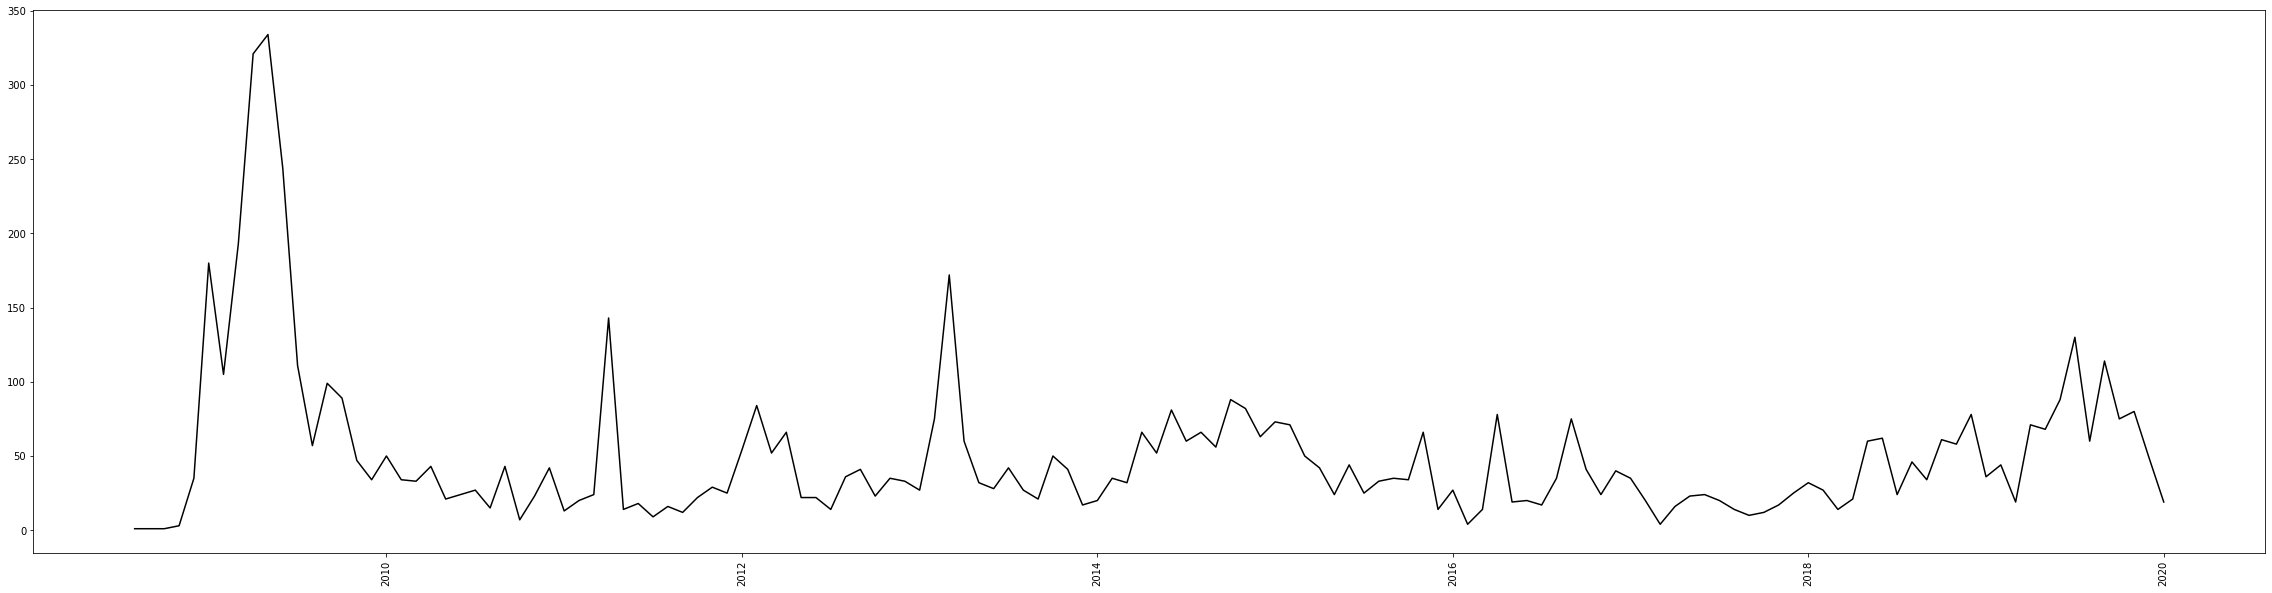

In [14]:
preckanje_meje = df.loc[df["TIP-DEJANJA"] == "PREPOVEDANO PREHAJANJE MEJE ALI OZEMLJA DRŽAVE"]
datum_preckanja = preckanje_meje.groupby(["MesecStoritve"])

mesec_stevilo = defaultdict(int)
for k,v in datum_preckanja:
    mesec_stevilo[k] = len(v)

mesec_stevilo = (list(mesec_stevilo.items()))
mesec_stevilo = [(float(int(k.split(".")[1]) + (int(k.split(".")[0])/12)),v) for k, v in mesec_stevilo if int(k.split(".")[1])>2007]
mesec_stevilo = sorted(mesec_stevilo, key=lambda x:x[0])
#print(mesec_stevilo)

datumi, vrednosti = zip(*mesec_stevilo)
plt.figure(figsize=(40,10))
plt.plot(datumi,vrednosti, color="black")
plt.xticks(rotation=90)
plt.show()

In [15]:
#https://stackoverflow.com/a/50205834
def plot_stacked_bar(data, series_labels, category_labels=None, 
                     show_values=False, value_format="{}", y_label=None, 
                     colors=None, grid=False, reverse=False):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    colors          -- List of color labels
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=color))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)

    plt.legend()

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

In [16]:
#Dictionary ENOTA{kaznivo dejanje: stevilo teh dejanj}
#idea Porazdelitev vrst kaznivih dejanj po posamezni enoti/občini/karkol se jim reče

#ZaporednaStevilkaKD;MesecStoritve;UraStoritve;OpisKD

kd_leto = df.groupby(['MesecStoritve', 'UraStoritve','ZaporednaStevilkaKD', 'OpisKD', 'PUStoritveKD'])

kraj_dejanje = defaultdict(lambda: defaultdict(int))
for k, v in kd_leto:
    #print(k, len(v))
    kraj_dejanje[k[-1]][k[-2].split(" - ")[1]] += len(v)

TOP 10 KAZNIVIH DEJANJ

In [17]:
df["TIP-DEJANJA"] = df.apply(lambda row: row["OpisKD"].split(" - ")[1], axis=1)
kd = df.groupby(["TIP-DEJANJA"])


##TOP 10 KAZNIVIH DEJANJ, ki jih bomo izrisali na grafu
top10 = sorted([(k, len(v)) for k, v in kd], key = lambda x: x[1], reverse=True)[:10]
top10Dejanja = [x[0] for x in top10]

In [18]:
vse = 0
KD_procenti = defaultdict(list)

for kraj, slovar in kraj_dejanje.items():
    if kraj in ["GPU", "DIREKTORAT ZA UPRAVNE NOTRANJE ZADEVE", "NI PODATKA"]: continue
    tmp = sorted([(k, v) for k, v in slovar.items()], key=lambda x: x[0])[::-1] # LIST OF TUPLES => (TATVINA : 23025)
    stevilo = sum([x[1] for x in tmp])
    print("%s:  %d" % (kraj, stevilo))
    procenti = 0
    ostalo = 0
    for x in tmp:
        if x[0] in top10Dejanja:
            procenti += x[1]/stevilo*100
            KD_procenti[x[0]].append(x[1]/stevilo*100)
            print("\t%s : %d  %f%%" % (x[0], x[1], x[1]/stevilo*100))
            vse += x[1]
            ostalo += x[1]
    KD_procenti["OSTALO"].append(100 - procenti)
    print("\tOSTALO: %d  %f%%" % (stevilo - ostalo, 100 - procenti))
    print("\n")

PU KRANJ:  95341
	VELIKA TATVINA : 11434  11.992742%
	TATVINA : 23025  24.150156%
	POŠKODOVANJE TUJE STVARI : 4653  4.880377%
	POSLOVNA GOLJUFIJA : 5371  5.633463%
	NEPLAÈEVANJE PREŽIVNINE : 6576  6.897347%
	NASILJE V DRUŽINI : 1719  1.803002%
	LAHKA TELESNA POŠKODBA : 2758  2.892774%
	KRŠITEV TEMELJNIH PRAVIC DELAVCEV : 2307  2.419735%
	GROŽNJA : 2774  2.909556%
	GOLJUFIJA : 6483  6.799803%
	OSTALO: 28241  29.621044%


PU MURSKA SOBOTA:  65207
	VELIKA TATVINA : 4840  7.422516%
	TATVINA : 10474  16.062693%
	POŠKODOVANJE TUJE STVARI : 2568  3.938227%
	POSLOVNA GOLJUFIJA : 2148  3.294125%
	NEPLAÈEVANJE PREŽIVNINE : 2412  3.698989%
	NASILJE V DRUŽINI : 2752  4.220406%
	LAHKA TELESNA POŠKODBA : 2137  3.277256%
	KRŠITEV TEMELJNIH PRAVIC DELAVCEV : 12867  19.732544%
	GROŽNJA : 2222  3.407610%
	GOLJUFIJA : 4795  7.353505%
	OSTALO: 17992  27.592130%


PU NOVO MESTO:  109241
	VELIKA TATVINA : 13005  11.904871%
	TATVINA : 24797  22.699353%
	POŠKODOVANJE TUJE STVARI : 4360  3.991175%
	POSLOVNA GO

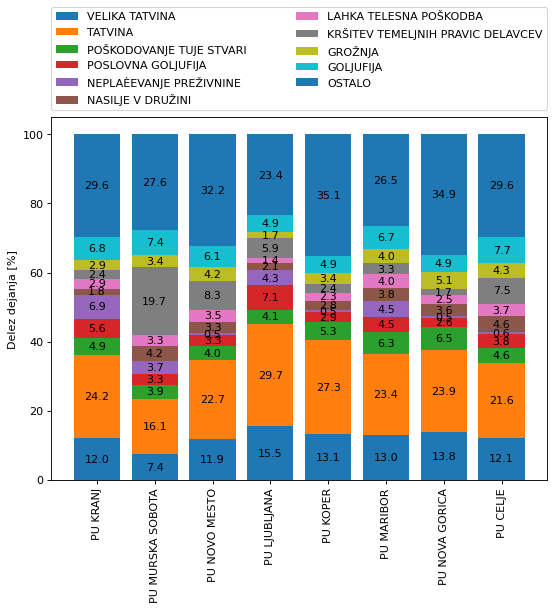

' fig, ax = plt.subplots()\n\nax.set_ylabel("Delez dejanja")\nax.set_title("Delez kaznivih dejanj po PU")\nax.legend()\nplt.show() '

In [19]:
header = ['VELIKA TATVINA', 'TATVINA', 'POŠKODOVANJE TUJE STVARI', 'POSLOVNA GOLJUFIJA', 'NEPLAÈEVANJE PREŽIVNINE', 'NASILJE V DRUŽINI', 'LAHKA TELESNA POŠKODBA', 'KRŠITEV TEMELJNIH PRAVIC DELAVCEV', 'GROŽNJA', 'GOLJUFIJA', 'OSTALO']
labels = [kraj for kraj, slovar in kraj_dejanje.items() if kraj not in ["GPU", "DIREKTORAT ZA UPRAVNE NOTRANJE ZADEVE", "NI PODATKA"]]
dataset = [v for k,v in KD_procenti.items()]

plt.figure(figsize=(8, 6), dpi=80)
plot_stacked_bar(
    dataset,
    header,
    category_labels=labels,
    show_values=True,
    value_format="{:.1f}",
    y_label= "Delez dejanja [%]",
)

l4 = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
plt.xticks(rotation=90)
plt.show()

""" fig, ax = plt.subplots()

ax.set_ylabel("Delez dejanja")
ax.set_title("Delez kaznivih dejanj po PU")
ax.legend()
plt.show() """

In [20]:
tujciKDs = [
"TATVINA",
"VELIKA TATVINA",
"GOLJUFIJA",
"POŠKODOVANJE TUJE STVARI",
"NASILJE V DRUŽINI",
"GROŽNJA",
"LAHKA TELESNA POŠKODBA",
"PONAREJANJE LISTIN",
"ZANEMARJANJE MLADOLETNE OSEBE IN SUROVO RAVNANJE",
"ODVZEM MLADOLETNE OSEBE",
"NASILNIŠTVO",
"PRIKRIVANJE",
"POVZROÈITEV SPLOŠNE NEVARNOSTI",
"PREPOVEDANO PREHAJANJE MEJE ALI OZEMLJA DRŽAVE",
"ROP",
"IZSILJEVANJE",
"SPOLNI NAPAD NA OSEBO,  MLAJŠO OD PETNAJST LET",
"HUDA TELESNA POŠKODBA",
"OGROŽANJE Z NEVARNIM ORODJEM PRI PRETEPU ALI PREPIRU",
"TRGOVINA Z LJUDMI",
"OŠKODOVANJE TUJIH PRAVIC",
"NEDOVOLJENA PROIZVODNJA IN PROMET OROŽJA ALI EKSPLOZIVA",
"POSILSTVO",
"ROPARSKA TATVINA",
"RAZŽALITEV",
"SPOLNO NASILJE",
"ZALEZOVANJE",
"POŽIG",
"PROTIPRAVEN ODVZEM PROSTOSTI",
"MUÈENJE ŽIVALI",
"OBREMENJEVANJE IN UNIÈEVANJE OKOLJA",
"JEMANJE PODKUPNINE",
"SPOLNA ZLORABA SLABOTNE OSEBE",
"UBOJ",
"POŠKODOVANJE ALI UNIÈENJE JAVNIH NAPRAV",
"JAVNO SPODBUJANJE SOVRAŠTVA, NASILJA ALI NESTRPNOSTI",
"UMOR",
"HUDODELSKO ZDRUŽEVANJE",
"ZLORABA PROSTITUCIJE",
"NEVARNA VOŽNJA V CESTNEM PROMETU",
"DAJANJE PODKUPNINE",
"OGROŽANJE JAVNEGA PROMETA Z NEVARNIM DEJANJEM ALI SREDSTVOM",
"OŠKODOVANJE JAVNIH SREDSTEV",
"PRIDOBIVANJE OSEB, MLAJŠIH OD PETNAJST LET, ZA SPOLE NAMENE",
"ORGANIZIRANJE DENARNIH VERIG IN NEDOVOLJENO PRIREJANJE IGER NA SREÈO",
"POŠKODOVANJE ALI UNIÈENJE STVARI, KI SO POSEBNEGA KULTURNEGA POMENA ALI NARAVNE VREDNOTE",
"NEZAKONITO RAVNANJE Z ZAŠÈITENIMI ŽIVALMI IN RASTLINAMI",
"POSEBNO HUDA TELESNA POŠKODBA",
"UGRABITEV",
"SODELOVANJE PRI PRETEPU",
"ONESNAŽENJE ŽIVIL ALI KRME",
"KRŠITEV MORALNIH AVTORSKIH PRAVIC",
"PRESLEPITEV KUPCEV",
"SPOLNI NAPAD NA OSEBO MLAJŠO OD 14 LET",
"ZAPUSTITEV POŠKODOVANCA V PROMETNI NESREÈI BREZ POMOÈI",
"POMOÈ STORILCU PO STORITVI KAZNIVEGA DEJANJA",
"UNIÈEVANJE GOZDOV",
"ONESNAŽENJE PITNE VODE",
"POVZROÈITEV PROMETNE NESREÈE IZ MALOMARNOSTI",
"SKRUNITEV TRUPLA",
"MUÈENJE",
"OGROŽANJE OSEB POD MEDNARODNIM VARSTVOM",
"SRAMOTITEV SLOVENSKEGA NARODA ALI NARODNIH SKUPNOSTI",
"NEZAKONIT RIBOLOV",
"OGROŽANJE OKOLJA S HRUPOM ALI SVETLOBO",
"PRENAŠANJE NALEZLJIVIH BOLEZNI",
"POVZROÈITEV NEVARNOSTI",
"BEG OSEBE, KI JI JE VZETA PROSTOST",
"OMOGOÈANJE BEGA OSEBI, KI JI JE VZETA PROSTOST",
"SPRAVLJANJE V SUŽENJSKO RAZMERJE",
"VOJNA HUDODELSTVA",
"TERORIZEM",
"GENOCID",
"UPOR OSEB, KI JIM JE VZETA PROSTOST",
"ŠÈUVANJE IN JAVNO POVELIÈEVANJE TERORISTIÈNIH DEJANJ",
"NEDOVOLJENA PRESADITEV DELOV ÈLOVEŠKEGA TELESA IN SPREMEMBA ÈLOVEŠKEGA GENOMA",
"HUDODELSTVA ZOPER ÈLOVEÈNOST",
"KRŠITEV SVOBODNE OPREDELITVE",
"KRŠITEV TAJNOSTI GLASOVANJA",
"NAPAD NA VOJAŠKO OSEBO, KI OPRAVLJA SLUŽBO",
"NOVAÈENJE IN USPOSABLJANJE ZA TERORIZEM",
"OBOROŽEN UPOR",
"SRAMOTITEV TUJE DRŽAVE ALI MEDNARODNE ORGANIZACIJE",
"NEDOVOLJEN POSEG V NOSEÈNOST",
"NEVESTNO PREGLEDOVANJE MESA ZA PREHRANO",
"NEVESTNO ZDRAVLJENJE",
"PRENAŠANJE KUŽNIH BOLEZNI PRI ŽIVALIH IN",
"TERORIZEM",
]

In [21]:
kd_leto = df.groupby(['PUStoritveKD'])
PU_tujci = defaultdict(lambda : defaultdict(lambda : [0,0]))

for k, v in kd_leto:
    if(k not in ["GPU", "DIREKTORAT ZA UPRAVNE NOTRANJE ZADEVE", "NI PODATKA"]):
        for value in v.values:
            if(value[33] not in tujciKDs):
                PU_tujci[k][value[1]][0] += 1
                if value[27] == "TUJE":
                    PU_tujci[k][value[1]][1] += 1
PU_tujci

PU_tujci1 = defaultdict(lambda : defaultdict(float))
for kraj, meseci in PU_tujci.items():
    for m in meseci:
        if int(m.split(".")[1]) > 2008:
            PU_tujci1[kraj][m] = PU_tujci[kraj][m][1]/PU_tujci[kraj][m][0]

##TUKEJ

PU_tujci2 = defaultdict(lambda : defaultdict(float))
PU_tujci1

for kraj, values in PU_tujci1.items():
    for datum, vrednost in values.items():
        PU_tujci2[datum][kraj] = vrednost
PU_tujci2

defaultdict(<function __main__.<lambda>()>,
            {'01.2009': defaultdict(float,
                         {'PU CELJE': 0.1464968152866242,
                          'PU KOPER': 0.5546875,
                          'PU KRANJ': 0.11764705882352941,
                          'PU LJUBLJANA': 0.26036644165863065,
                          'PU MARIBOR': 0.04411764705882353,
                          'PU MURSKA SOBOTA': 0.041666666666666664,
                          'PU NOVA GORICA': 0.2962962962962963,
                          'PU NOVO MESTO': 0.026785714285714284}),
             '02.2009': defaultdict(float,
                         {'PU CELJE': 0.16447368421052633,
                          'PU KOPER': 0.532258064516129,
                          'PU KRANJ': 0.15151515151515152,
                          'PU LJUBLJANA': 0.1956882255389718,
                          'PU MARIBOR': 0.046242774566473986,
                          'PU MURSKA SOBOTA': 0.12903225806451613,
               

In [22]:
generateGif(PU_tujci2.items(), "Kazniva dejanja tujcev po letih", "./temp/KDTUJCIpoLETIH.gif" );